[*********************100%***********************]  1 of 1 completed

cuda:0


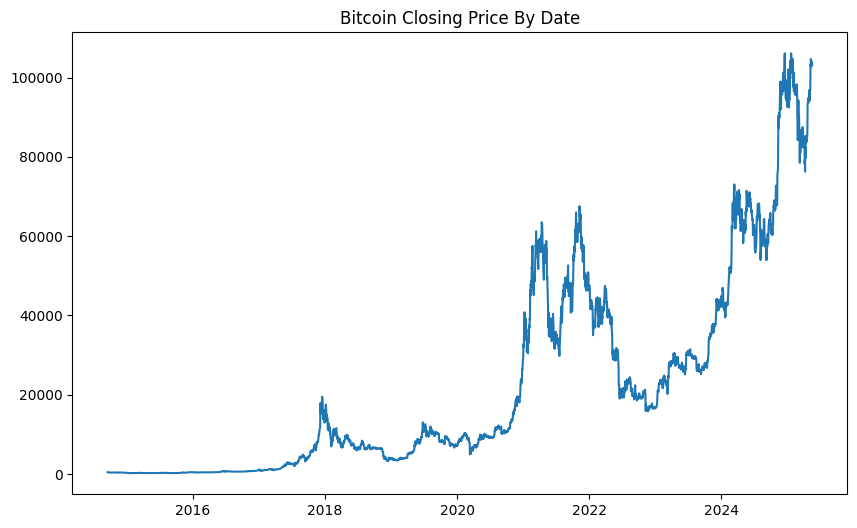

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import yfinance as yf
import pandas as pd

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

bitcoin = yf.download("BTC-USD",start="2010-05-18",end="2025-05-18")['Close']

plt.figure(figsize=(10,6))
plt.plot(bitcoin['BTC-USD'])
plt.title("Bitcoin Closing Price By Date")
plt.savefig("images/closingbtc.png")
plt.show()




In [9]:

bitcoin = bitcoin.reset_index()

training = bitcoin.iloc[:,1:2].values

train_size = int(len(training)* .60)

train_data = training[:train_size]
test_data = training[train_size:]
print(len(train_data))
print(len(test_data))

2337
1559


In [10]:

scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


def slider(df,seq_length):
    X,y = [],[]
    for i in range(len(df) - seq_length):
        X_ = df[i:(seq_length + i)]
        y_ = df[(seq_length + i)]
        X.append(X_)
        y.append(y_)
    return np.array(X),np.array(y)

seq_length = 1
X_train,y_train = slider(train_data,seq_length)
X_test,y_test = slider(test_data,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([2336, 1, 1])
torch.Size([1558, 1, 1])
torch.Size([2336, 1])
torch.Size([1558, 1])


In [11]:

class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,X):
        h0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        c0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = LSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss(reduction="sum")
epochs = 1000

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:
        print(f'Epoch {epoch+1} train loss: {loss.item()}')

Epoch 1 train loss: 73.32610321044922
Epoch 2 train loss: 67.36316680908203
Epoch 3 train loss: 61.97635269165039
Epoch 4 train loss: 57.16361618041992
Epoch 5 train loss: 52.923919677734375
Epoch 6 train loss: 49.255348205566406
Epoch 7 train loss: 46.15499496459961
Epoch 8 train loss: 43.61791229248047
Epoch 9 train loss: 41.63437271118164
Epoch 10 train loss: 40.18545913696289
Epoch 11 train loss: 39.23713684082031
Epoch 12 train loss: 38.73367691040039
Epoch 13 train loss: 38.59257507324219
Epoch 14 train loss: 38.70500946044922
Epoch 15 train loss: 38.94539260864258
Epoch 16 train loss: 39.189517974853516
Epoch 17 train loss: 39.335025787353516
Epoch 18 train loss: 39.31576919555664
Epoch 19 train loss: 39.1058235168457
Epoch 20 train loss: 38.71415710449219
Epoch 21 train loss: 38.17433547973633
Epoch 22 train loss: 37.53315734863281
Epoch 23 train loss: 36.84072494506836
Epoch 24 train loss: 36.14297866821289
Epoch 25 train loss: 35.47690200805664
Epoch 26 train loss: 34.8679695

In [12]:
model.eval()
with torch.no_grad():
    for epoch in range(epochs):
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(),y_test) 
        print(f'train loss: {loss.item()}; test loss: {test_loss.item()}')



train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.6074490547180176
train loss: 0.17908987402915955; test loss: 2.607449054

In [13]:
with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = bitcoin.iloc[train_size + seq_length:]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Price": actual_rescaled.flatten(),
    "Predicted Price": pred_rescaled.flatten()
})

print(comparison_df.head(29))
print(comparison_df.tail(20))

         Date  Actual Price  Predicted Price
0  2021-02-10  44918.183594     47194.558594
1  2021-02-11  47909.332031     45585.832031
2  2021-02-12  47504.851562     48665.558594
3  2021-02-13  47105.511719     48248.878906
4  2021-02-14  48717.289062     47837.562500
5  2021-02-15  47945.058594     49498.082031
6  2021-02-16  49199.871094     48702.363281
7  2021-02-17  52149.007812     49995.457031
8  2021-02-18  51679.796875     53036.988281
9  2021-02-19  55888.128906     52552.859375
10 2021-02-20  56099.519531     56897.667969
11 2021-02-21  57539.949219     57116.074219
12 2021-02-22  54207.320312     58604.613281
13 2021-02-23  48824.421875     55161.632812
14 2021-02-24  49705.328125     49608.492188
15 2021-02-25  47093.851562     50516.515625
16 2021-02-26  46339.757812     47825.546875
17 2021-02-27  46188.453125     47049.027344
18 2021-02-28  45137.769531     46893.246094
19 2021-03-01  49631.242188     45811.789062
20 2021-03-02  48378.984375     50440.144531
21 2021-03

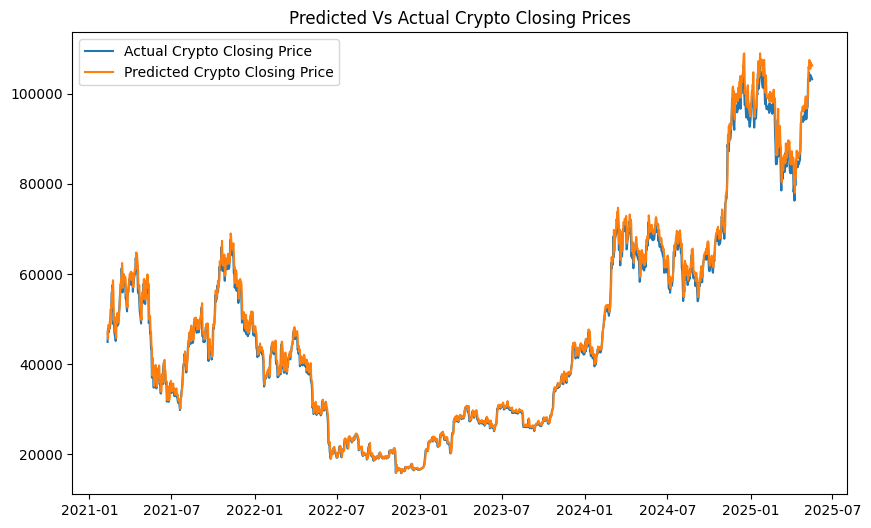

In [15]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df['Actual Price'],label="Actual Crypto Closing Price")
plt.plot(comparison_df['Date'],comparison_df['Predicted Price'],label="Predicted Crypto Closing Price")
plt.title("Predicted Vs Actual Crypto Closing Prices")
plt.savefig("images/actual_comparedto_predicted.png")
plt.legend()
plt.show()